# Deep Learning
**Multilayer Perceptron (MLP)**: In this homework you are required to implement and train a 3-layer neural network to classify images of hand-written digits from the MNIST dataset. The input to the network will be a 28 × 28-pixel image, which is converted into a 784-dimensional vector. The output will be a vector of 10 probabilities (one for each digit). Specifically, the network you create should implement a function $g: \mathbb{R}^{784} \rightarrow \mathbb{R}^{10}$, where:

$$\mathbf{z}_{1} = \mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)}$$
$$\mathbf{h}_1 = ReLU(\mathbf{z}_1)$$
$$\mathbf{z}_2 = \mathbf{W}^{(2)}\mathbf{h}_1 + \mathbf{b}^{(2)}$$
$$\hat{\mathbf{y}} = g(\mathbf{x}) = Softmax(\mathbf{z}_2)$$

**Forward Propagation**: Compute the intermediate outputs $\mathbf{z}_{1}$, $\mathbf{h}_{1}$, $\mathbf{z}_{2}$, and $\hat{\mathbf{y}}$ as the directed graph shown below:

![jupyter](./img/mlp.jpg)

**Loss function**: After forward propagation, you should use the cross-entropy loss function: 
$$ f_{CE}(\mathbf{W}^{(1)},\mathbf{b}^{(1)}, \mathbf{W}^{(2)}, \mathbf{b}^{(2)}) =  - \frac{1}{n}\sum_{i=1}^{n} \sum_{k=1}^{10} \mathbf{y}_k^{(i)} \log \hat{\mathbf{y}}_k^{(i)} $$
where $n$ is the number of examples.

**Backwards Propagation**: To train the neural network, you should use stochastic gradient descent (SGD). 

# Question 1:
Compute the individual gradient for each term

$$ \frac{\partial f_{CE}}{\partial \mathbf{W}^{(2)}}  =  \frac{1}{n}\sum_{i=1}^{n}  (\hat{\mathbf{y}}^{(i)} - \mathbf{y}^{(i)})  (\mathbf{h_1}^{(i)})^{T}  $$


$$ \frac{\partial f_{CE}}{\partial \mathbf{b}^{(2)}} =  \frac{1}{n}\sum_{i=1}^{n}  (\hat{\mathbf{y}}^{(i)} - \mathbf{y}^{(i)})   $$


$$ \frac{\partial f_{CE}}{\partial \mathbf{W}^{(1)}} = \frac{1}{n}\sum_{i=1}^{n}  ((\hat{\mathbf{y}}^{(i)} - \mathbf{y}^{(i)})^{T} \mathbf W^{(2)})^{T} \circ sgn(\mathbf{z_1}^{(i)}) (\mathbf{x}^{(i)})^{T}$$ 
    
    
$$ \frac{\partial f_{CE}}{\partial \mathbf{b}^{(1)}} =  \frac{1}{n}\sum_{i=1}^{n}  ((\hat{\mathbf{y}}^{(i)} - \mathbf{y}^{(i)})^{T} \mathbf W^{(2)})^{T} \circ sgn(\mathbf{z_1}^{(i)})   $$

# Question 2: 
Implement stochastic gradient descent for the network shown above in the *Starter Code* Below

# Question 3: 
Verify that your implemented gradient functions are correct using a numerical derivative approximation in *scipy.optimize.check_grad*

See the call to check grad in the starter code. 

Note that: the discrepancy should be less than 0.01.

# Question 4: 
Train the network using proper hyper-parameters (batch size, learning rate etc), and report the train accuracy and test accuracy in the *Starter Code* Below


**NOTE THAT**: You only need to submit this '.ipynb' file.

# Starter Code: 

In [114]:
import numpy as np
import scipy.optimize
import scipy.special
import matplotlib.pyplot as plt

NUM_INPUT = 784  # Number of input neurons
NUM_HIDDEN = 50  # Number of hidden neurons
NUM_OUTPUT = 10  # Number of output neurons
NUM_CHECK = 5  # Number of examples on which to check the gradient

def relu(X):
    return (np.abs(X) + X)/2

def relu_back(X):
    X_grad = np.copy(X)
    X_grad[X_grad <= 0] = 0
    X_grad[X_grad > 0] = 1
    return X_grad

def softmax(X):
    t = np.exp(X)
    a = np.exp(X) / np.sum(t, axis=0, keepdims=True) # compute softamx by column
    return a

def cross_entropy(Y_hat, Y):
    N = Y_hat.shape[1]
    ce = -np.sum(Y*np.log(Y_hat))/N
    return ce

# data = np.array([[5,4,3],[5,4,3]])
# print(softmax(data))

In [115]:
# Given a vector w containing all the weights and biased vectors, extract
# and return the individual weights and biases W1, b1, W2, b2.
# This is useful for performing a gradient check with check_grad.
def unpack (w):
    # W1 of (50, 784), b1 of (50, 1), W2 of (10, 50), b2 of (10, 1)
    W1 = w[ : NUM_HIDDEN*NUM_INPUT].reshape(NUM_HIDDEN, NUM_INPUT)
    b1 = w[NUM_HIDDEN*NUM_INPUT : NUM_HIDDEN*NUM_INPUT + NUM_HIDDEN].reshape(NUM_HIDDEN, 1)
    W2 = w[NUM_HIDDEN*NUM_INPUT+NUM_HIDDEN : NUM_HIDDEN*NUM_INPUT+NUM_HIDDEN+NUM_OUTPUT*NUM_HIDDEN].reshape(NUM_OUTPUT, NUM_HIDDEN)
    b2 = w[NUM_HIDDEN*NUM_INPUT+NUM_HIDDEN+NUM_OUTPUT*NUM_HIDDEN : ].reshape(NUM_OUTPUT, 1)
    return W1, b1, W2, b2

# Given individual weights and biases W1, b1, W2, b2, concatenate them and
# return a vector w containing all of them.
# This is useful for performing a gradient check with check_grad.
def pack (W1, b1, W2, b2):
    w = np.concatenate((W1.flatten(), b1.flatten(), W2.flatten(), b2.flatten()))
    return w

# Load the images and labels from a specified dataset (train or test).
def loadData (which):
    images = np.load("data/mnist_{}_images.npy".format(which))
    labels = np.load("data/mnist_{}_labels.npy".format(which))
    return images, labels

In [121]:
# Given training images X, associated labels Y, and a vector of combined weights
# and bias terms w, compute and return the cross-entropy (CE) loss. You might
# want to extend this function to return multiple arguments (in which case you
# will also need to modify slightly the gradient check code below).
def fCE (X, Y, w):
    # X.shape= (784, 10000), Y.shape= (10, 10000)
    # W1 of (50, 784), b1 of (50, 1), W2 of (10, 50), b2 of (10, 1)
    W1, b1, W2, b2 = unpack(w)
    Z1 = np.matmul(W1, X) + b1
    H1 = relu(Z1)
    # H1.shape= (50, 10000)
    Z2 = np.matmul(W2, H1) + b2
    Y_hat = softmax(Z2)
    # Y_hat.shape(10, 10000)
    cost = cross_entropy(Y_hat, Y)
    return cost, Y_hat

# Given training images X, associated labels Y, and a vector of combined weights
# and bias terms w, compute and return the gradient of fCE. You might
# want to extend this function to return multiple arguments (in which case you
# will also need to modify slightly the gradient check code below).
def gradCE (X, Y, w):
    # X.shape= (784, 10000), Y.shape= (10, 10000)
    # W1 of (50, 784), b1 of (50, 1), W2 of (10, 50), b2 of (10, 1)
    W1, b1, W2, b2 = unpack(w)
    
    Z1 = np.matmul(W1, X) + b1
    H1 = relu(Z1)
    Z2 = np.matmul(W2, H1) + b2
    Y_hat = softmax(Z2)
    
    grad_b2 = np.mean(Y_hat - Y, axis=1).reshape(-1, 1)
    # grad_b2 of (10, 1)
    grad_W2 = np.matmul(Y_hat-Y, H1.T) / X.shape[1]
    # grad_W2 of (10, 50)
    
    delta = np.matmul((Y_hat - Y).T, W2) * relu_back(Z1.T)
    # shape of np.matmul((Y_hat - Y).T, W2) is (10000, 50), delta of (10000, 50)
    grad_b1 = np.mean(delta.T, axis=1).reshape(-1, 1)
    # grad_b1 of (50, 1)
    grad_W1 = np.matmul(delta.T, X.T) / X.shape[1]
    # grad_W1 of (50, 784)
    
    grad = pack(grad_W1, grad_b1, grad_W2, grad_b2)
    return grad

# Given training and testing datasets and an initial set of weights/biases b,
# train the NN.
## return the train accuracy and the test accuracy
def train (trainX, trainY, testX, testY, w):
    train_acc, test_acc = [], []

    epochs = 500
    minibatch = 32
    learning_rate = 0.01
    
    for epoch in range(epochs):
        # print("Training epoch {}".format(epoch))
        for batch in range(int(trainX.shape[1]/minibatch)):
            Xbatch = trainX[:, batch*minibatch:(batch+1)*minibatch]
            Ybatch = trainY[:, batch*minibatch:(batch+1)*minibatch]
            w_grad = gradCE(Xbatch, Ybatch, w)
            w = w - w_grad * learning_rate
        
        CE, Y_hat = fCE(trainX, trainY, w)
        pred = np.argmax(Y_hat, axis=0)
        gold = np.argmax(trainY, axis=0)
        train_acc.append(np.mean(pred == gold))
        # print("train_acc:", np.mean(pred == gold))
        
        CE, Y_hat = fCE(testX, testY, w)
        pred = np.argmax(Y_hat, axis=0)
        gold = np.argmax(testY, axis=0)
        # print("test_acc:", np.mean(pred == gold))
        test_acc.append(np.mean(pred == gold))

    return np.array(train_acc), np.array(test_acc)

len(trainX):  10000
len(testX):  5000
My implemented cost and gradient functions are correct
total epochs trained:  500
best accuracy 0.9442 is reached at epoch 365


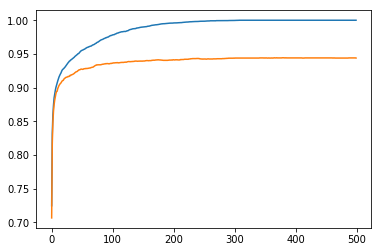

In [122]:
if __name__ == "__main__":
    # Load data
    trainX, trainY = loadData("train")
    testX, testY = loadData("test")

    print("len(trainX): ", len(trainX))
    print("len(testX): ", len(testX))
    
    # Initialize weights randomly
    W1 = 2*(np.random.random(size=(NUM_INPUT, NUM_HIDDEN))/NUM_INPUT**0.5) - 1./NUM_INPUT**0.5
    b1 = 0.01 * np.ones(NUM_HIDDEN)
    W2 = 2*(np.random.random(size=(NUM_HIDDEN, NUM_OUTPUT))/NUM_HIDDEN**0.5) - 1./NUM_HIDDEN**0.5
    b2 = 0.01 * np.ones(NUM_OUTPUT)
    
    # 根据顶部的表达式，各参数的尺寸应该为(对于单样本)：
    # x of (784, 1)
    # W1 of (50, 784), b1 of (50, 1), W2 of (10, 50), b2 of (10, 1)
    # 作业中所给出的数据格式不是很符合惯例，进行转置调整
    
    trainX, trainY = trainX.T, trainY.T
    testX, testY = testX.T, testY.T
    W1, W2 = W1.T, W2.T
    
    # print(trainX.shape, testX.shape)
    # print(W1.shape, b1.shape, W2.shape, b2.shape)
    # 调整之后身心舒畅，可以按照第一题中的表达式进行计算梯度
    
    w = pack(W1, b1, W2, b2)
    
    # Check that the gradient is correct on just a few examples (randomly drawn).
    idxs = np.random.permutation(trainX.shape[0])[0:NUM_CHECK]
    discrepancy = scipy.optimize.check_grad(lambda w_: fCE(np.atleast_2d(trainX[:,idxs]), np.atleast_2d(trainY[:,idxs]), w_)[0], \
                                    lambda w_: gradCE(np.atleast_2d(trainX[:,idxs]), np.atleast_2d(trainY[:,idxs]), w_), \
                                    w)
    
    if discrepancy < 0.01:
        print("My implemented cost and gradient functions are correct")

    # Train the network and return the train accuracy and test accuracy
    train_acc, test_acc = train(trainX, trainY, testX, testY, w)
    epochs = len(train_acc)
    max_iter = test_acc.argmax()
    max_acc = test_acc.max()
    
    print("total epochs trained: ", epochs)
    print("best accuracy {} is reached at epoch {}".format(max_acc, max_iter))
    
    plt.plot(range(epochs), train_acc)
    plt.plot(range(epochs), test_acc)
    